# Load Libraries

In [34]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, ParameterGrid
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Import Data

In [2]:
X_train = pd.read_csv('0_X_train.csv', index_col='Id')
X_valid = pd.read_csv('1_X_valid.csv', index_col='Id')
X_test  = pd.read_csv('2_X_test.csv', index_col='Id')

y_train = pd.read_csv('0_y_train.csv', index_col='Id')
y_valid = pd.read_csv('1_y_valid.csv', index_col='Id')
y_test  = pd.read_csv('2_y_test.csv', index_col='Id')

num_vars = ['age', 'time_spent', 'banner_views', 'banner_views_old', 'days_elapsed_old', 'X4']

X_pred = pd.read_csv("TEST_KAGGLE.csv", index_col="Id")

In [48]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

col_transformer = ColumnTransformer(
    transformers=[("numeric", numeric_transformer, num_vars)],
    remainder='passthrough'
)

col_transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['age', 'time_spent', 'banner_views',
                                  'banner_views_old', 'days_elapsed_old',
                                  'X4'])])

In [49]:
X_train_pp = col_transformer.transform(X_train)
X_valid_pp = col_transformer.transform(X_valid)
X_test_pp = col_transformer.transform(X_test)

X_train_transformed = pd.DataFrame(X_train_pp, columns=X_train.columns)
X_train_transformed.describe()

X_valid_transformed = pd.DataFrame(X_valid_pp, columns=X_train.columns)
X_test_transformed = pd.DataFrame(X_valid_pp, columns=X_train.columns)

In [45]:
knn1 = KNeighborsRegressor(n_neighbors=1)
knn1.fit(X_train_transformed, y_train)

KNeighborsRegressor(n_neighbors=1)

In [46]:
y_hat = knn1.predict(X_train_transformed)
rmse = np.sqrt(mean_squared_error(y_train, y_hat, squared=False))
rmse

0.0

In [50]:
y_hat_valid = knn1.predict(X_valid_transformed)
rmse = np.sqrt(mean_squared_error(y_valid, y_hat_valid, squared=False))
rmse

0.7002959704822554

In [51]:
y_hat_test = knn1.predict(X_test_transformed)
rmse = np.sqrt(mean_squared_error(y_test, y_hat_test, squared=False))
rmse

0.837906374110815

# Find Best K

In [12]:
folds = KFold(n_splits=10 , shuffle=True, random_state=1)

knn_best = KNeighborsRegressor()
hyper_parameters = {"n_neighbors" : np.arange(1, 50, 2)}

In [52]:
knnCV = GridSearchCV(estimator=knn_best, param_grid=hyper_parameters, scoring="neg_mean_squared_error",
                       cv=folds)
knnCV.fit(X_train_transformed, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])},
             scoring='neg_mean_squared_error')

In [53]:
resCV = knnCV.cv_results_

test_MSEs = -resCV["mean_test_score"]
std_test_MSEs = resCV["std_test_score"] / np.sqrt(10)
k_grid = resCV["param_n_neighbors"].data

index_best = np.argmin(test_MSEs) # index of the k value with the lowest MSE estimate
best_k = k_grid[index_best]
best_k

9

In [54]:
one_std_rule_best_k = np.min(k_grid[test_MSEs <= test_MSEs[index_best] + std_test_MSEs[index_best]])
one_std_rule_best_k

9

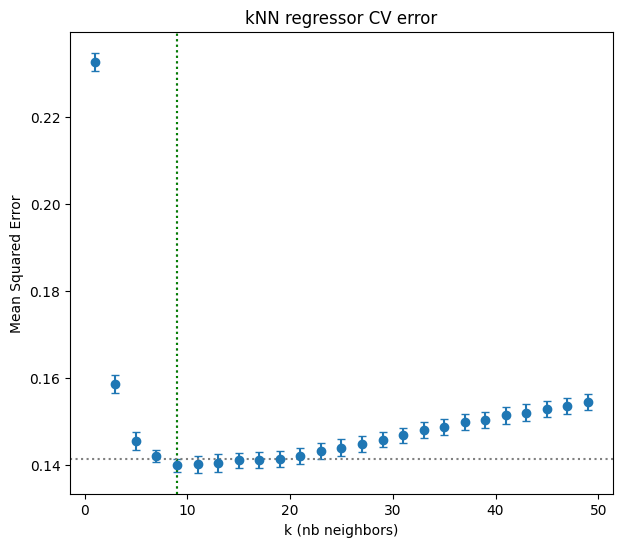

In [55]:
plt.figure(figsize=(7,6))
plt.errorbar(x=k_grid, y=test_MSEs, yerr=std_test_MSEs, fmt='o', capsize=3)

plt.axvline(best_k, ls='dotted', color="grey")#vertical line at the k yielding minimum CV MSE
plt.axvline(one_std_rule_best_k, ls='dotted', color="green")#vertical line at best k value according to 1 std err rule
plt.axhline(test_MSEs[index_best] + std_test_MSEs[index_best], ls='dotted', color="grey")

plt.title("kNN regressor CV error")
plt.xlabel('k (nb neighbors)')
plt.ylabel('Mean Squared Error')
plt.show()

# Optimal KNN

In [56]:
knn_opt = KNeighborsRegressor(n_neighbors=one_std_rule_best_k)
knn_opt.fit(X_train_transformed, y_train)

KNeighborsRegressor(n_neighbors=9)

In [57]:
y_hat = knn_opt.predict(X_train_transformed)
rmse = np.sqrt(mean_squared_error(y_train, y_hat, squared=False))
rmse

0.5763289013870909

In [58]:
y_hat_valid = knn_opt.predict(X_valid_transformed)
rmse = np.sqrt(mean_squared_error(y_valid, y_hat_valid, squared=False))
rmse

0.6166251211680558

In [59]:
y_hat_test = knn_opt.predict(X_test_transformed)
rmse = np.sqrt(mean_squared_error(y_test, y_hat_test, squared=False))
rmse

0.7677930573114177